In [15]:
import cassio

In [19]:
ASTRA_DB_APPLICATION_TOKEN = "AstraCS:ikuIaLudWgdOarqisaqseLrl:e3a0cd7042cf973430712b9d6da8f9b94a5423ace753bf9b795330e364ed346ardd"
ASTRA_DB_ID = "5062827b-bd28-4e0a-839e-57ff3f23114bce"

In [20]:
cassio.init(token=ASTRA_DB_APPLICATION_TOKEN,database_id= ASTRA_DB_ID)

In [ ]:
! pip install langchain_community

In [ ]:
! pip install -U tiktoken langchain-groq langchainhub chromadb langchain langgraph langchain_huggingface

In [25]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader

# Load data from web pages
urls = ["https://lilianweng.github.io/posts/2023-06-23-agent/" ,
       "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
       "https://lilianweng.github.io/posts/2023-10-25-adv-attack-11m/"]

docs = [WebBaseLoader(urls).load() for urls in urls]
doc_list = [item for sublist in docs for item in sublist]
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500, chunk_overlap=0)
doc_splits = text_splitter.split_documents(doc_list)

In [ ]:
doc_list

In [27]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")


In [28]:
from langchain.vectorstores.cassandra import Cassandra

astra_vector_store = Cassandra(embedding=embeddings,
                               table_name="qa_mini_demo",
                               session=None,
                               keyspace=None)

In [29]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
astra_vector_store.add_documents(doc_splits)
astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)

In [62]:
retriever = astra_vector_store.as_retriever()
retriever.invoke("what is an agent?")

[Document(id='6c29f86cd83e43f59cad7659b1ed5d25', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log"}, page_content='Planning is essentially in order to optimize believability at the moment vs in time.\nPrompt template: {Intro of an agent X}. Here is X\'s plan today in broad strokes: 1)\nRelationships between agents and observations of one agent by another are all taken into consideration for p

## langGraph Application

In [31]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

In [32]:
class RouteQuery(BaseModel):
    """Route a User Query to an appropriate function."""

    datasource: Literal["vectorstore", "wiki_search"] = Field(
        ...,
        description="Given a user question choose to route it to Wikipedia or vector Store"
    )

In [ ]:
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv

# Load the .env file
load_dotenv()

groq_api_key = os.getenv('groq_api_key')
print(groq_api_key)

In [36]:
llm=ChatGroq(groq_api_key=groq_api_key, model_name="llama-3.1-70b-versatile")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001CC369AD790>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001CC37295750>, model_name='llama-3.1-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [37]:
structured_llm_router = llm.with_structured_output(RouteQuery)

In [39]:
# Prompt
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)
question_router = route_prompt | structured_llm_router

In [40]:
print(question_router.invoke({"question": "What is an agent?"}))

datasource='vectorstore'


In [41]:
print(question_router.invoke({"question": "Who is Prabhas?"}))


datasource='wiki_search'


### Get Now get the actual Wikipedia tool to get the Data

In [42]:
! pip install wikipedia

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11705 sha256=92f7dd3de48acfb4967f8a223c8894ffe7a08d603e528cac2dede74d89dfcde4
  Stored in directory: c:\users\phane\appdata\local\pip\cache\wheels\8f\ab\cb\45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia


In [80]:
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun

api_wrapper = WikipediaAPIWrapper(top_k_results=1)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper)

In [81]:
wiki.run("Who is Prabhas?")

'Page: Prabhas\nSummary: Uppalapati Venkata Suryanarayana Prabhas Raju ([pɾabʱaːs] born 23 October 1979), known mononymously as Prabhas, is an Indian actor who predominantly works in Telugu cinema. He is one of the highest-paid actors in Indian cinema and has been featured in Forbes India\'s Celebrity 100 list since 2015. Referred to in the media as the "Rebel Star", he has appeared in over 20 films, and has received seven Filmfare Awards nominations, a Nandi Award, and a SIIMA Award. \nPrabhas made his acting debut with the drama Eeswar (2002), and later attained his breakthrough with the action romance Varsham (2004). He went on to star in other commercially successful films such as Chatrapathi (2005), Bujjigadu (2008), Billa (2009), Darling (2010), Mr. Perfect (2011), and Mirchi (2013), winning the Nandi Award for Best Actor for his performance in the lattermost. He went on to play a dual role in the epic action duology Baahubali: The Beginning (2015) and Baahubali 2: The Conclusion

# Ai Agents Application using LangGraph

In [82]:
from typing import List

from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
       """
    question: str
    generation: str
    documents: List[str]

In [83]:
from langchain.schema import Document

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    questions = state["question"]

    # Retrieval
    documents = retriever.invoke(questions)
    return {"documents": documents, "question": questions}
    

In [84]:
def wiki_search(state):
    """
    wiki search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---wikipedia---")
    print("---HELLO--")
    question = state["question"]
    print(question)

    # Wiki search
    docs = wiki.invoke({"query": question})
    #print(docs["summary"])
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {"documents": wiki_results, "question": question}

In [85]:

def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [86]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

##Define the Nodes
workflow.add_node("wiki_search", wiki_search) # websearch
workflow.add_node("retrieve", retrieve) # retrieve documents from vectorstore


## Build the graph

workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
    }
)

workflow.add_edge("retrieve", END)
workflow.add_edge("wiki_search", END)

# Coimpile
app=workflow.compile()

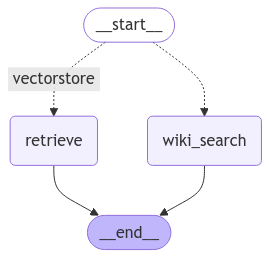

In [87]:
from IPython.display import Image,display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    # This can happen if the graph is too large to display
    pass

### Final Usage 

In [88]:
from pprint import pprint

# Run
inputs = {
    "question": "What is agent?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'][0].dict()['metadata']['description'])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
('Building agents with LLM (large language model) as its core controller is a '
 'cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer '
 'and BabyAGI, serve as inspiring examples. The potentiality of LLM extends '
 'beyond generating well-written copies, stories, essays and programs; it can '
 'be framed as a powerful general problem solver.\n'
 'Agent System Overview In a LLM-powered autonomous agent system, LLM '
 'functions as the agent’s brain, complemented by several key components:')


C:\Users\phane\AppData\Local\Temp\ipykernel_25832\2686642801.py:16: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  pprint(value['documents'][0].dict()['metadata']['description'])


In [89]:
from pprint import pprint

# Run
inputs = {
    "question": "Kalki 2898"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'])

---ROUTE QUESTION---
---ROUTE QUESTION TO Wiki SEARCH---
---wikipedia---
---HELLO--
Kalki 2898
"Node 'wiki_search':"
'\n---\n'
Document(metadata={}, page_content="Page: Kalki 2898 AD\nSummary: Kalki 2898 AD (Telugu: [kəlkɪ]; stylised onscreen as KΛLKI 2898 – Λ.D) is a 2024 Indian Telugu-language epic science fiction film directed by Nag Ashwin and produced by Vyjayanthi Movies. The film stars Amitabh Bachchan, Kamal Haasan, Prabhas, Deepika Padukone, and Disha Patani. Inspired by Hindu scriptures, it is the first instalment in a planned Kalki Cinematic Universe. Set in a post-apocalyptic world in the year 2898 AD, the film follows a select group who are on a mission to save lab subject SUM-80's unborn child, Kalki.\nThe film was officially announced in February 2020 and had working title as Project K. Principal photography commenced a year later in July 2021 due to COVID-19 pandemic. It was shot sporadically over the next three years extensively in Ramoji Film City, Hyderabad and wrapp